# Question 2
Implementations of trust region methods and other related functions can be found in the `algorithms` directory. I've modulized them and imported them to this jupyter notebook to answer further questions.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from functions import *
from algorithms.linalg_utils import *
from algorithms.trust_region import trust_region as tr
from algorithms.trust_region import step_finders as sf

%matplotlib inline

## Defining helper functions
We need to have information about each `bk` and `rho` in trust region algorithm iterations, so we define a helper function to capture those values in each iteration.

In [3]:
def get_trust_region_information(f, g, hf, x0, delta_0, max_delta, etha, step_finder, repair_hessian=True, eps=1e-5):
    
    x = x0
    delta = delta_0
    iterations = 0
    rhos = []
    original_bs = []

    while True:

        iterations += 1
        b = hf(x)
        if is_psd(b):
            original_bs.append(1)
        else:
            original_bs.append(-1)
        if repair_hessian:
            b = repair_psd(b)

        p = step_finder(g(x), b, delta)
        rho = (f(x) - f(x+p)).astype('f') / (tr.model(f, g, b, x, p, delta) - tr.model(f, g, b, x+p, p, delta))
        rhos.append(rho)

        if rho < .25:
            delta = .25 * delta
        elif rho >= .75 and np.isclose(la.norm(p), delta, 1e-4):
            delta = min(2*delta, max_delta)

        if rho > etha:
            x = x + p
        elif np.allclose(p, np.zeros(p.shape), eps):
            break
            
    return rhos, original_bs

## Visualizing trust region information in each step
Here we visualize the `rho` and `original (non-repaired) bk` for each iteration for different step selection methods.
Each row represents a different starting point and in each row, the left figure corresponds to the `rho` values and the right figure corresponds to the `original bk` being positive semi definite(1) or not(-1).

### Dog Leg step finder

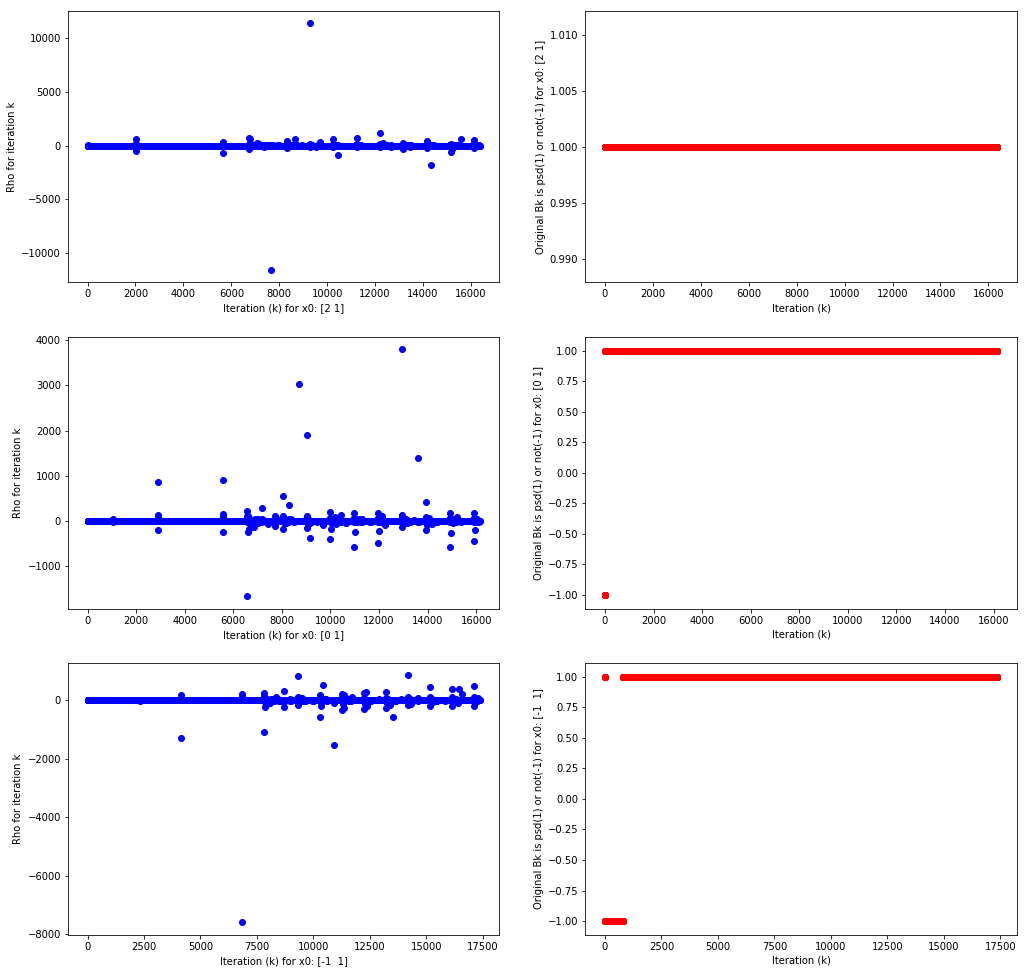

In [12]:
trust_region_info = [get_trust_region_information(f1, g1, h1, x1s[i], .1, 1, .15, step_finder=sf.dogleg_step_finder) for i in range(len(x1s))]

plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x1s)):
    
    rh = trust_region_info[i][0]
    bs = trust_region_info[i][1]
    x = [j for j in range(len(rh))]
    
    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.scatter(x, rh, color='blue', label='Rho')
    plt.xlabel('Iteration (k) for x0: %s' % x1s[i])
    plt.ylabel('Rho for iteration k')
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.scatter(x, bs, color='red', label='Original Bk is psd')
    plt.xlabel('Iteration (k)')
    plt.ylabel('Original Bk is psd(1) or not(-1) for x0: %s' % x1s[i])


### Cacuhy point step finder

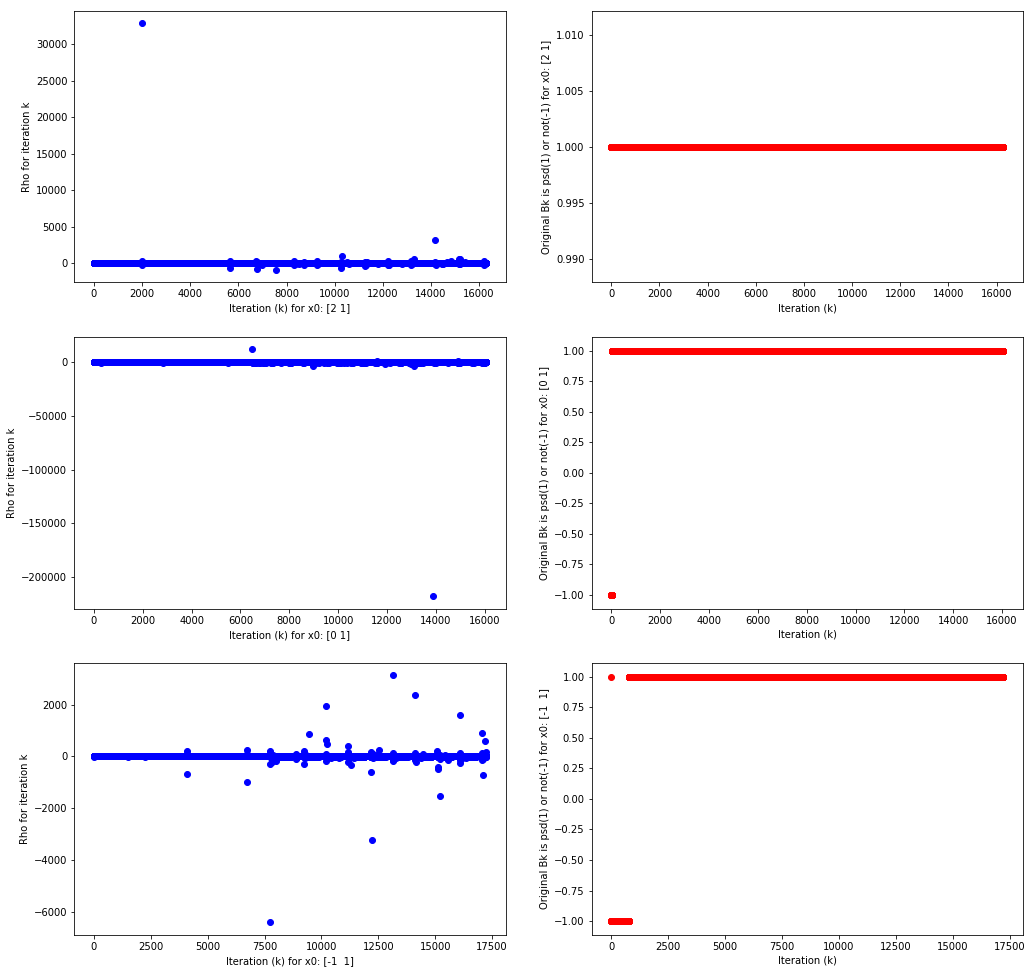

In [14]:
trust_region_info = [get_trust_region_information(f1, g1, h1, x1s[i], .1, 1, .15, step_finder=sf.cauchy_point_step_finder) for i in range(len(x1s))]

plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x1s)):
    
    rh = trust_region_info[i][0]
    bs = trust_region_info[i][1]
    x = [j for j in range(len(rh))]
    
    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.scatter(x, rh, color='blue', label='Rho')
    plt.xlabel('Iteration (k) for x0: %s' % x1s[i])
    plt.ylabel('Rho for iteration k')
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.scatter(x, bs, color='red', label='Original Bk is psd')
    plt.xlabel('Iteration (k)')
    plt.ylabel('Original Bk is psd(1) or not(-1) for x0: %s' % x1s[i])


## Analyzing the `bk`
As it can be seen, the exact hessian is PSD in the path to the minimum, and therefore, is a good assumption for the `bk` parameter in each approximation.
Also, we could use other methods for approximating `bk` and applying the correction algorithm to adjust its eigenvalues and make it PSD.

## Testing the algorithm
Finally, we test the results of each alogirthm on the `f2` function using two different step finders (Dog Leg and Cauchy Point methods).
As seen below, both methods converge to the minimum.

In [18]:
x, fx, iterations = tr.trust_region(f2, g2, h2, x2s[0], .1, 1, .15, sf.dogleg_step_finder)
print('Result in %d iterations:' % iterations)
print('%s -> %f' % (x, fx))

Result in 61 iterations:
[0.00010001] -> -0.000100


In [20]:
x, fx, iterations = tr.trust_region(f2, g2, h2, x2s[0], .1, 1, .15, sf.cauchy_point_step_finder)
print('Result in %d iterations:' % iterations)
print('%s -> %f' % (x, fx))

Result in 63 iterations:
[0.00010002] -> -0.000100
